# Alan Turing Institute Data Dive 2017

## Where can we build more houses?

### Identification of brownfield sites from satellite data using Machine Learning

#### (Exploratory data analysis by B. Soergel, Institute of Astronomy, Cambridge)


Brownfield sites are sites which have previously been developed and built on, often for industrial use. Now they are disused, which makes them candidate sites for the construction of new homes. In particular, building on existing brownfield sites would reduce urban sprawl into the green belt (for some more details see e.g. http://www.bbc.co.uk/schools/gcsebitesize/geography/urban_environments/urbanisation_medcs_rev5.shtml).

Using multi-band satellite image of the Greater Manchester area and a pilot register of brownfield sites, we can extract the spectral signature of these sites. We can then train a classification algorithm on these data. The classifier could then be applied to satellite images from other cities, where there is no brownfield register available.

In [1]:
import gdal
# import osgeo
from osgeo import osr
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
%matplotlib inline

Image data was provided by Satellite Applications Catapult: https://sa.catapult.org.uk/

In [2]:
datapath = '/media/bjoern/data/datadive/SatelliteApplicationsCatapult/'
#Manchester 
imname = 'SEN2_20170326_lat54lon217_T30UWE_vmsk_sharp_rad_srefdem_stdsref_tif.tif'
#Glasgow
#imname = 'SEN2_20170408_lat55lon371_T30UVG_vmsk_sharp_rad_srefdem_stdsref_tif.tif'
path = os.path.join(datapath,imname)

In [3]:
#read geotiff
ds = gdal.Open(path)    
data = ds.ReadAsArray()

In [4]:
#some settings for zoom-in on Manchester
xmin,xmax = 4250,5750
ymin,ymax = 7000,8000
plt.rcParams['xtick.labelsize'] = 20 #40
plt.rcParams['ytick.labelsize'] = 20 #40
extent = (0,(xmax-xmin)/1e2,0,(ymax-ymin)/1e2)

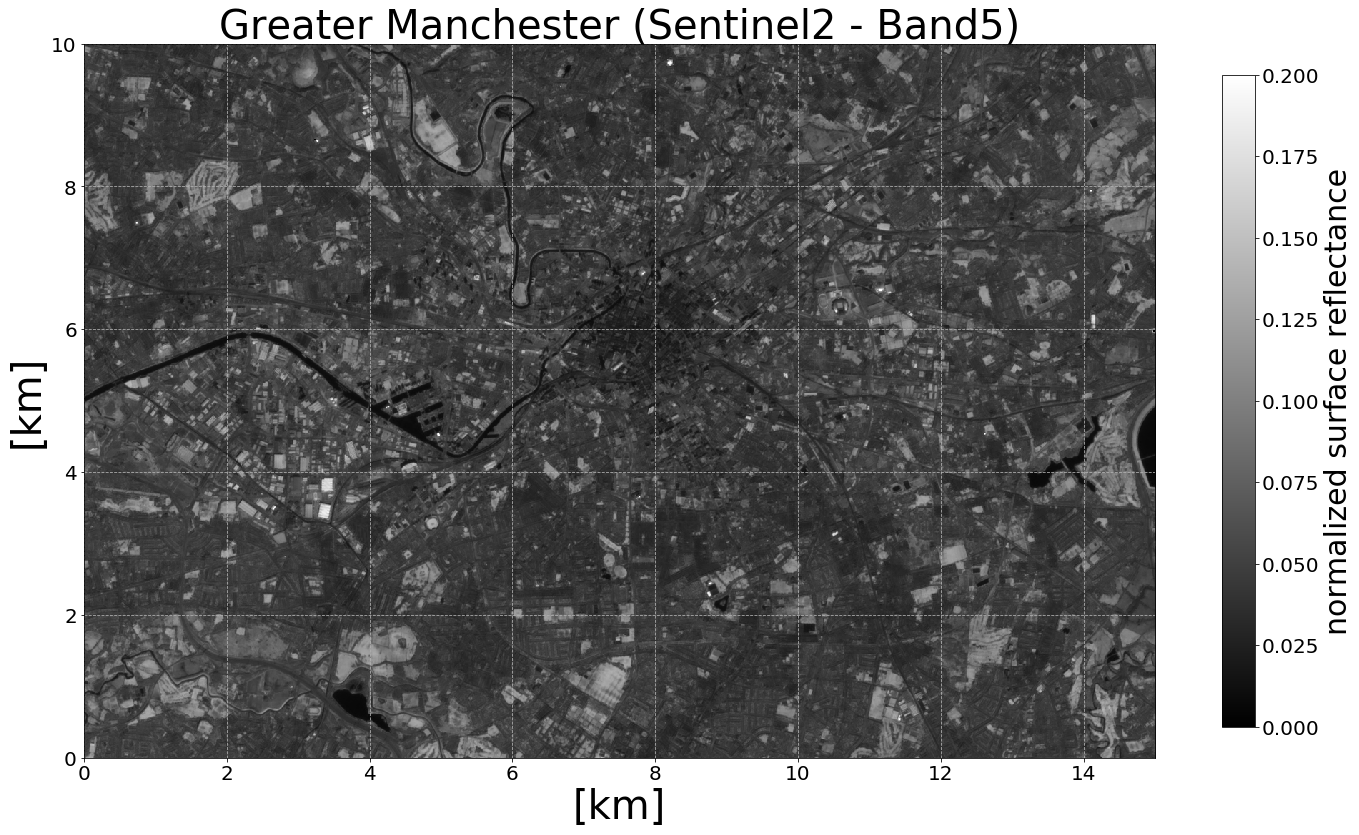

In [5]:
#band5
arr=data[4] 
plt.figure(figsize=(24,24))    
plt.imshow(arr[ymin:ymax,xmin:xmax].astype('float')/float(arr.max()),cmap=plt.cm.gray,
           vmin=0,vmax=0.2,extent=extent)
cb = plt.colorbar(shrink=0.5)
cb.set_label('normalized surface reflectance',fontsize=30)
plt.grid(ls='--')
plt.xlabel('[km]',fontsize=40)
plt.ylabel('[km]',fontsize=40)
plt.title('Greater Manchester (Sentinel2 - Band5)',fontsize=40)
#plt.savefig('Manchester_overview_Band5.png',dpi=300,bbox_inches='tight')

91.14799375
99.853425
123.57835
156.43478125


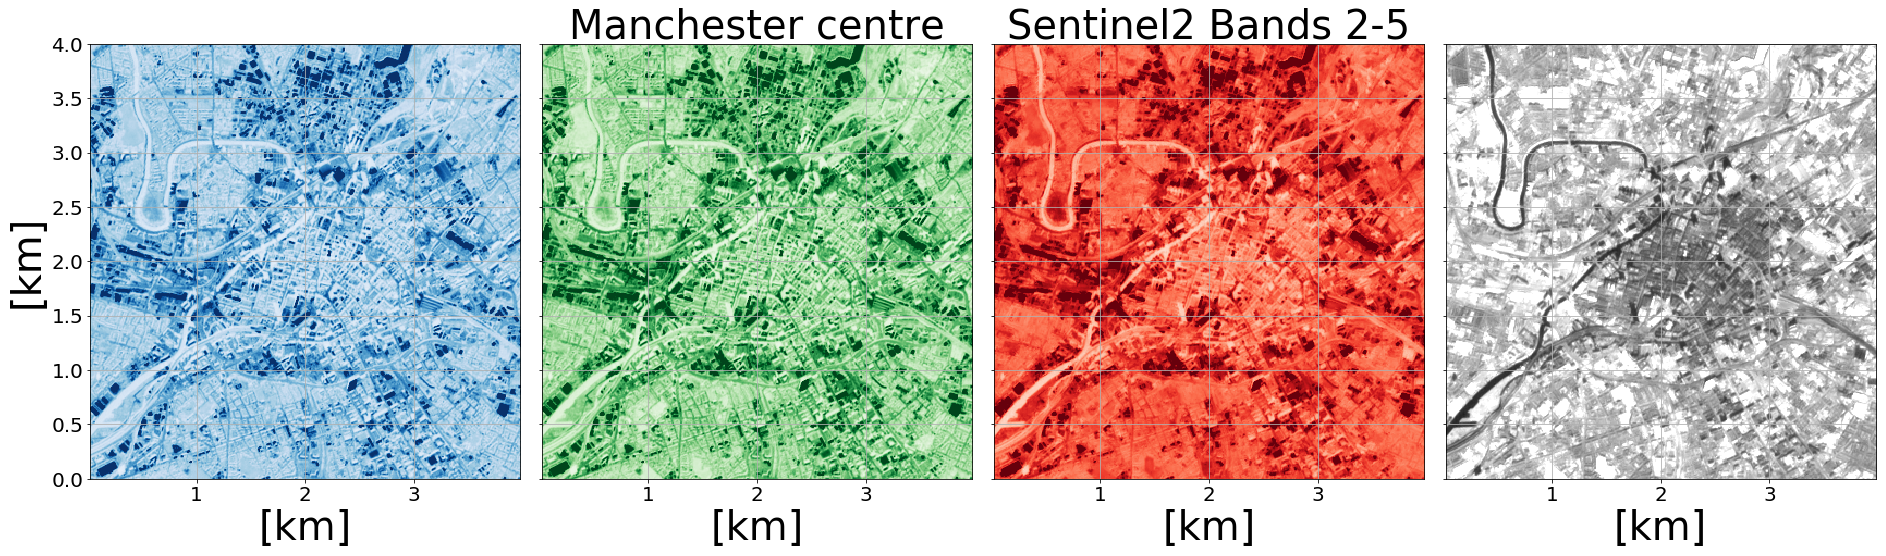

In [6]:
xmin1,xmax1 = 4800,5200
ymin1,ymax1 = 7200,7600
extent1 = (0,((xmax1-xmin1))/1e2,0,((ymax1-ymin1))/1e2)

#plt.figure(figsize=(24,24)) 
fig,axes = plt.subplots(1,4,figsize=(32,8),sharey=True)
for ax,band,cmap in zip(axes,[1,2,3,4],[plt.cm.Blues,plt.cm.Greens,plt.cm.Reds,plt.cm.gray]):
    marr = data[band,ymin1:ymax1,xmin1:xmax1].astype('float')
    print(marr.mean())
    ax.imshow(marr,
               cmap=cmap,
               vmin=0,vmax=200,
               extent=extent1)
    #plt.colorbar()
    ax.grid()
    ax.set_xlabel('[km]',fontsize=40)
axes[0].set_ylabel('[km]',fontsize=40)
plt.subplots_adjust(wspace=0.05)
axes[1].set_title('Manchester centre',fontsize=40)
axes[2].set_title('Sentinel2 Bands 2-5',fontsize=40)

### further exploration after datadive

getting coordinates from geotiff
e.g. https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file

In [7]:
# get the existing coordinate system
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 

#get the point to transform, pixel (0,0) in this case
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()

In [8]:
gt
# left, x-axis east, x-axis north, upper, y-axis east, y-axis north
# i.e. origin is upper left

(499980.0, 10.0, 0.0, 6000000.0, 0.0, -10.0)

In [9]:
#get the coordinates in lat long
latlong = transform.TransformPoint(gt[0],gt[3])#minx,miny) 
latlong

(-3.0003062006352015, 54.148104103480236, 0.0)

Manchester coordinates are:  -2.244644 (long), 53.483959 (lat),

### Manchester Brownfield site register

downloaded from https://mappinggm.org.uk/gmodin/?lyrs=brownfield_manchester,brownfield_bolton,brownfield_bury,brownfield_oldham,brownfield_rochdale,brownfield_salford,brownfield_stockport,brownfield_tameside,brownfield_trafford,brownfield_wigan#os_maps_light/11/53.0763/-3.2104

In [10]:
df = pd.read_csv('./greatermanchester_brownfieldregister_2016-07-01_rev1.1.csv')
df.head()

SiteReference                                        SiteName  \
0      1040-BOL                     Urban Village 5 St Helena S   
1      1041-BOL  MINERVA HOUSE, CHORLEY STREET, BOLTON, BL1 4AL   
2      1042-BOL                                  Central Street   
3      1045-BOL                  King Street/Deansgate, BL1 2JR   
4      1048-BOL                               Breightmet Street   

                                      SiteAddress UPRN  \
0                     Urban Village 5 St Helena S  NaN   
1  MINERVA HOUSE, CHORLEY STREET, BOLTON, BL1 4AL  NaN   
2                                  Central Street  NaN   
3                  King Street/Deansgate, BL1 2JR  NaN   
4                               Breightmet Street  NaN   

  CoordinateReferenceSystem      GeoX       GeoY  Hectares    PlanningStatus  \
0                     WGS84 -2.433991  53.578990      0.44  Not permissioned   
1                     WGS84 -2.436546  53.579959      1.97      Permissioned   
2                     WGS84 -2.430566  53.580282      1.40  Not permissioned   
3                     WGS84 -2.432159  53.579010      0.22  Not permissioned   
4                     WGS84 -2.422052  53.577167      0.48  Not permissioned   

                                     PlanningHistory    ...    Street Town  \
0  https://www.planningpa.bolton.gov.uk/online-ap...    ...       NaN  NaN   
1  https://www.planningpa.bolton.gov.uk/online-ap...    ...       NaN  NaN   
2  https://www.planningpa.bolton.gov.uk/online-ap...    ...       NaN  NaN   
3  https://www.planningpa.bolton.gov.uk/online-ap...    ...       NaN  NaN   
4  https://www.planningpa.bolton.gov.uk/online-ap...    ...       NaN  NaN   

  Postcode PlanningHistoryNotes  CoordinateReferenceSystem1 GeoX1 GeoY1  \
0      NaN                  NaN                         NaN   NaN   NaN   
1      NaN                  NaN                         NaN   NaN   NaN   
2      NaN                  NaN                         NaN   NaN   NaN   
3      NaN                  NaN                         NaN   NaN   NaN   
4      NaN                  NaN                         NaN   NaN   NaN   

  LocalPlanningConstructionStatus SHAPE_AREA SHAPE_LEN  
0                            None        NaN       NaN  
1                         Outline        NaN       NaN  
2                            None        NaN       NaN  
3                            None        NaN       NaN  
4                            None        NaN       NaN  

[5 rows x 37 columns]

In [11]:
# missing coordinates
df.GeoX.isnull().sum()

1

In [12]:
#using inverse transform from above to translate lat,lon into UTM
InverseTransform = osr.CoordinateTransformation(new_cs,old_cs)
easting,northing,_ = InverseTransform.TransformPoint(df.GeoX[0],df.GeoY[0])
easting,northing

(537474.7983435913, 5936830.489048484)

pixel coordinates, adapted from
https://gis.stackexchange.com/questions/221292/retrieve-pixel-value-with-geographic-coordinate-as-input-with-gdal


In [13]:
xOrigin = gt[0]
yOrigin = gt[3]
pixelWidth = gt[1]
pixelHeight = gt[5] #removed minus for consistency

#testing for one point
point = (easting,northing)#list of X,Y coordinates

#pixel coordinates
col = int((point[0] - xOrigin) / pixelWidth)
row = int((point[1] - yOrigin) / pixelHeight) #changed order
print(row,col, arr[row,col])

6316 3749 131


### get pixel coordinates of all brownfield sites and plot them on map

In [14]:
coords = []

for i in range(df.shape[0]):
    try:
        easting,northing,_ = InverseTransform.TransformPoint(df.GeoX[i],df.GeoY[i])
        point = (easting,northing)
        col = int((point[0] - xOrigin) / pixelWidth)
        row = int((point[1] - yOrigin) / pixelHeight)
    except:
        print('missing coordinate: skipping')
        row,col = None,None
    coords.append((row,col))
coords = np.array(coords)

missing coordinate: skipping


(0, 40.0)

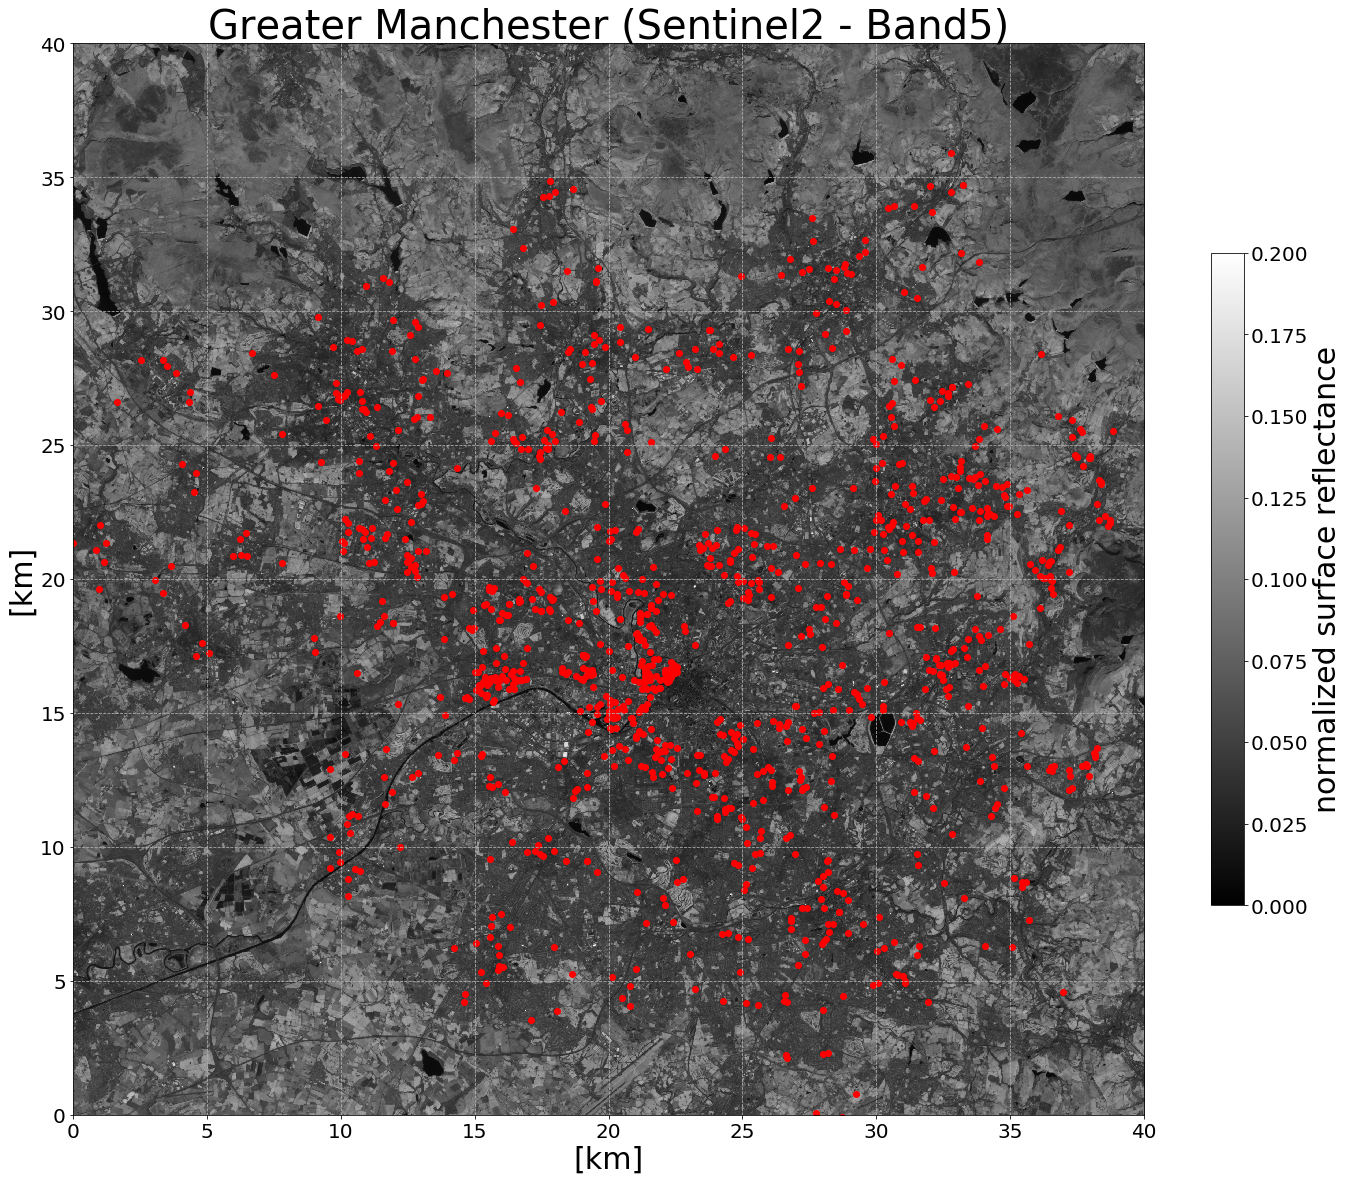

In [15]:
#image boundaries (pixel size is 10m)
xmin2,xmax2 = 2750,6750
ymin2,ymax2 = 5000,9000
extent2 = (0,(xmax2-xmin2)/100,0,(ymax2-ymin2)/100)

fig,ax = plt.subplots(figsize=(24,24)) 
im = ax.imshow(arr[ymin2:ymax2,xmin2:xmax2]/arr.max(),
               cmap=plt.cm.gray,vmin=0,vmax=1./5.,
              extent=extent2)
cb = plt.colorbar(im,shrink=0.5)
cb.set_label('normalized surface reflectance',fontsize=30)
ax.grid(ls='--')
ax.set_title('Greater Manchester (Sentinel2 - Band5)',fontsize=40)
ax.set_xlabel('[km]',fontsize=30)
ax.set_ylabel('[km]',fontsize=30)

for (row,col) in coords:
    if row is None: continue
    ax.scatter((col-xmin2)/100,(ymax2-row)/100,color='r')
    
ax.set_xlim(0,(xmax2-xmin2)/100)
ax.set_ylim(0,(ymax2-ymin2)/100)

# plt.savefig('Manchester_brownfields.png',dpi=100,bbox_inches='tight')

pixel values

In [16]:
vals_all = []
for d in data:
    vals = [ d[c[0],c[1]] for c in coords if c[0] is not None ]
    vals_all.append(vals)
vals_all = np.array(vals_all)
vals_all

array([[ 75,  90,  95, ...,  63,  59, 130],
       [ 85, 104, 107, ...,  71,  77, 156],
       [ 89, 120, 123, ...,  62,  80, 183],
       ..., 
       [147, 200, 149, ..., 201, 268, 199],
       [174, 223, 173, ..., 174, 248, 211],
       [158, 200, 164, ..., 130, 162, 201]], dtype=uint16)

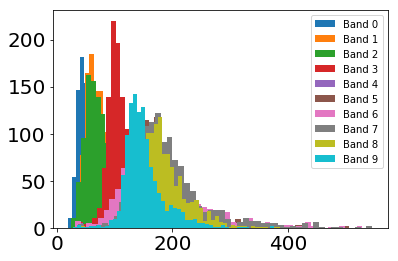

In [17]:
for i,vals in enumerate(vals_all):
    plt.hist(vals,bins=50,label='Band {}'.format(i))
plt.legend()

### average "spectrum" of brownfield sites

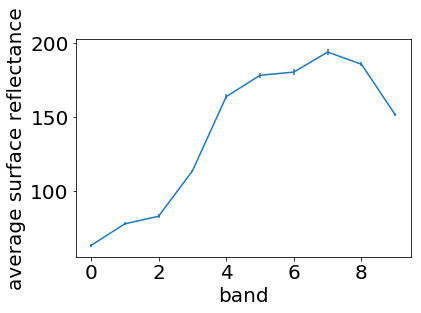

In [18]:
x=np.arange(10)
plt.errorbar(x,vals_all.mean(axis=1),yerr=vals_all.std(axis=1)/np.sqrt(vals_all.shape[1]))
plt.xlabel('band',fontsize=20)
plt.ylabel('average surface reflectance',fontsize=20)

### select random point for comparison

In [19]:
#compare with random points in image
coords_random = np.random.randint(low=0,high=ds.RasterXSize-1,size=coords.size).reshape(coords.shape)

In [20]:
vals_random = []
for d in data:
    vals = [ d[c[0],c[1]] for c in coords_random if c[0] is not None ]
    vals_random.append(vals)
vals_random = np.array(vals_random)
vals_random

array([[ 66,  37,  22, ...,  45,  43,  53],
       [ 68,  52,  25, ...,  72,  68,  75],
       [ 81,  56,  31, ...,  59,  48,  70],
       ..., 
       [166, 254, 112, ..., 312, 417, 246],
       [178, 209, 113, ..., 237, 221, 202],
       [154, 130,  69, ..., 152, 124, 138]], dtype=uint16)

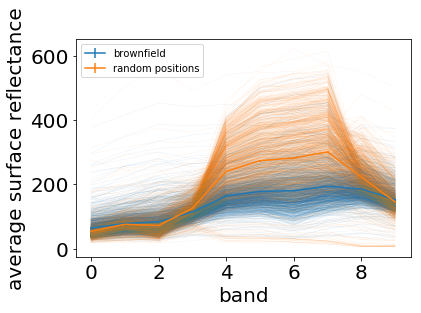

In [21]:
plt.errorbar(x,vals_all.mean(axis=1),yerr=vals_all.std(axis=1)/np.sqrt(vals_all.shape[1]),
            label = 'brownfield')
plt.errorbar(x,vals_random.mean(axis=1),yerr=vals_random.std(axis=1)/np.sqrt(vals_random.shape[1]),
            label = 'random positions')
plt.xlabel('band',fontsize=20)
plt.ylabel('average surface reflectance',fontsize=20)

ax = plt.gcf().gca()
for va,vr in zip(vals_all.T,vals_random.T):
    ax.plot(x,va,c='C0',lw=0.2,alpha=0.2)
    ax.plot(x,vr,c='C1',lw=0.2,alpha=0.2)

ax.legend()

Brownfield sites have a spectral signature that is distinct from random sites. Most notably, they do not show an increase in the near infrared. This makes sense, I would expect brownfield sites to have little to no vegetation. Furthermore, brownfield sites have smaller scatter than random sites. This reflects the relatively uniform characteristics of brownfield sites, in contrast to the more diverse nature of random sites (housing, parks, agriculture,...).

(1.5, 2.8)

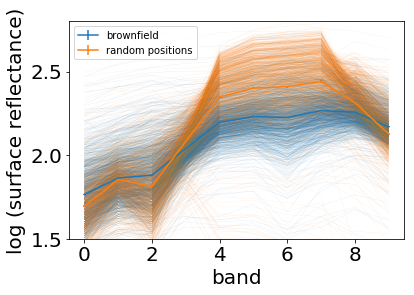

In [22]:
# same with "magnitude" = log (reflectance)
log_vals_all = np.log10(vals_all)
log_vals_random = np.log10(vals_random)

plt.errorbar(x,log_vals_all.mean(axis=1),yerr=log_vals_all.std(axis=1)/np.sqrt(log_vals_all.shape[1]),
            label = 'brownfield')
plt.errorbar(x,log_vals_random.mean(axis=1),yerr=log_vals_random.std(axis=1)/np.sqrt(log_vals_random.shape[1]),
            label = 'random positions')
plt.xlabel('band',fontsize=20)
plt.ylabel('log (surface reflectance)',fontsize=20)

ax = plt.gcf().gca()
for va,vr in zip(log_vals_all.T,log_vals_random.T):
    ax.plot(x,va,c='C0',lw=0.2,alpha=0.2)
    ax.plot(x,vr,c='C1',lw=0.2,alpha=0.2)

ax.legend()
ax.set_ylim(1.5,2.8)

### clustering in "magnitude" (log reflectance) space

In [23]:
#create pandas data frames for better handling
valdf = pd.DataFrame(data=log_vals_all.T,columns=['Band{}'.format(i) for i in range(vals_all.shape[0])])
valdf = valdf.assign(kind='brownfield')

In [24]:
#also for randoms
randf = pd.DataFrame(data=log_vals_random.T,columns=['Band{}'.format(i) for i in range(vals_all.shape[0])])
randf = randf.assign(kind='random')

In [25]:
#stack both data frames
stackdf = pd.concat([valdf,randf],axis=0)
stackdf.head()

Band0     Band1     Band2     Band3     Band4     Band5     Band6  \
0  1.875061  1.929419  1.949390  2.071882  2.117271  2.143015  2.103804   
1  1.954242  2.017033  2.079181  2.193125  2.252853  2.260071  2.212188   
2  1.977724  2.029384  2.089905  2.123852  2.149219  2.152288  2.173186   
3  1.913814  1.919078  2.004321  2.025306  2.053078  2.071882  2.130334   
4  1.716003  1.832509  1.875061  2.068186  2.198657  2.235528  2.257679   

      Band7     Band8     Band9        kind  
0  2.167317  2.240549  2.198657  brownfield  
1  2.301030  2.348305  2.301030  brownfield  
2  2.173186  2.238046  2.214844  brownfield  
3  2.086360  2.193125  2.173186  brownfield  
4  2.276462  2.336460  2.235528  brownfield

In [26]:
stackdf.tail()

Band0     Band1     Band2     Band3     Band4     Band5     Band6  \
1156  1.748188  1.924279  1.963788  2.220108  2.457882  2.513218  2.537819   
1157  1.672098  1.869232  1.869232  2.107210  2.363612  2.411620  2.424882   
1158  1.653213  1.857332  1.770852  2.113943  2.406540  2.450249  2.460898   
1159  1.633469  1.832509  1.681241  2.045323  2.498311  2.578639  2.598790   
1160  1.724276  1.875061  1.845098  2.079181  2.315970  2.357935  2.367356   

         Band7     Band8     Band9    kind  
1156  2.575188  2.546543  2.326336  random  
1157  2.453318  2.372912  2.184691  random  
1158  2.494155  2.374748  2.181844  random  
1159  2.620136  2.344392  2.093422  random  
1160  2.390935  2.305351  2.139879  random

### explore clustering

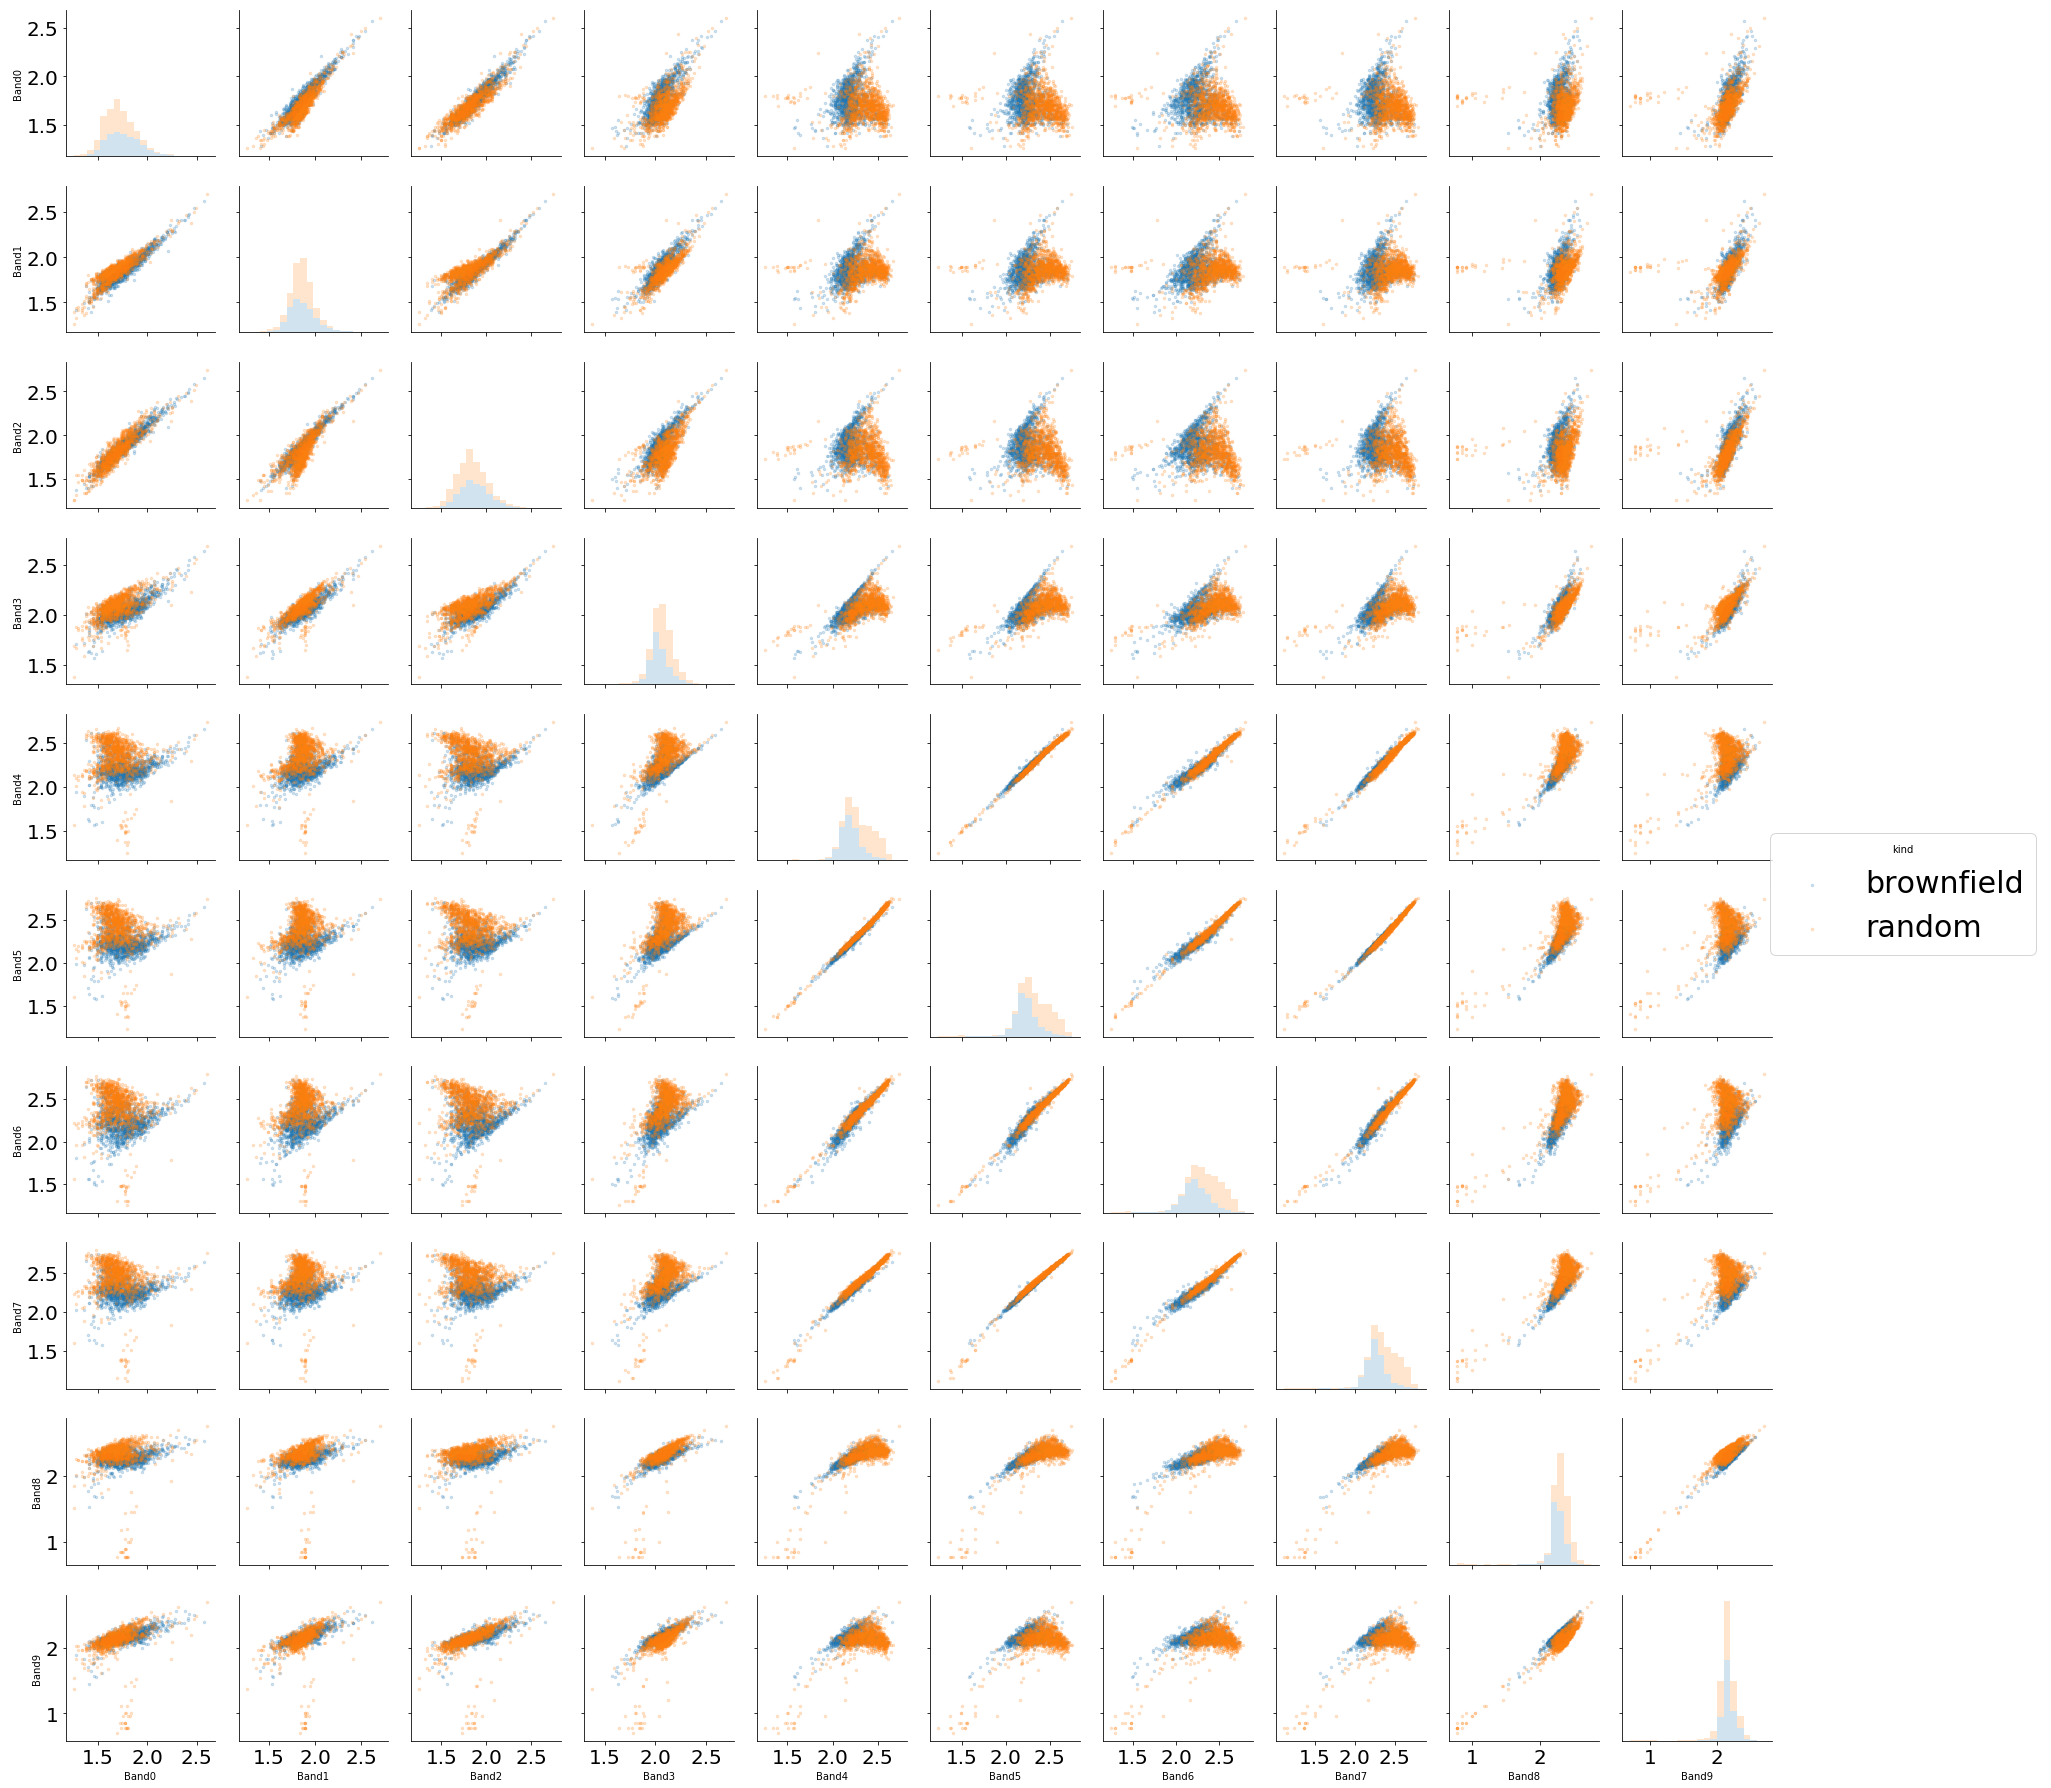

In [27]:
g = sn.PairGrid(stackdf,hue='kind')
g.map_diag(plt.hist,bins=20,alpha=0.2)
g.map_offdiag(plt.scatter,s=6,alpha=0.2)
g.add_legend(fontsize=30)
# plt.savefig('log_reflectance_brownfield_vs_rand.png')

The different clustering in log(reflectance) space across the 10 different bands should make it possible to identify brownfield sites.

## A basic classification

steps:

- pre-process data (scaling and dimensionality reduction)
- fit model
- evaluate prediction

(in parts adapted from scikit-learn tutorial by Corran Webster, Enthought)


In [28]:
#replacing tag with numerical class
stackdf['kind'] = stackdf['kind'].map({'brownfield': 1, 'random': 0})

In [29]:
#convert to numpy array for sklearn input
stackarr = np.array(stackdf)
stackdat = stackarr[:,:-1]
stackclass = stackarr[:,-1]
stackclass.size

2321

In [30]:
#randomize order (previously stacked data frame was sorted)
b = np.arange(stackclass.size)
np.random.shuffle(b)
features = stackdat[b]
target = stackclass[b]

### split into testing and training data
(saving 20% for testing)

In [31]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2)
data_train.shape, data_test.shape, target_train.shape, target_test.shape

((1856, 10), (465, 10), (1856,), (465,))

### pre-processing
For some classifiers (e.g. Support Vector Machines), we need scale the data so that every feature has mean = 0 and unit variance; otherwise different features will not be weighted equally. Because we are using the logarithm of the surface reflectance, the range of the different features is already similar, but we will still do same basic preprocessing.

In [32]:
from sklearn.preprocessing import RobustScaler

#Robust scaler that uses only the central 50% 
scaler = RobustScaler()
scaler.fit(data_train)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

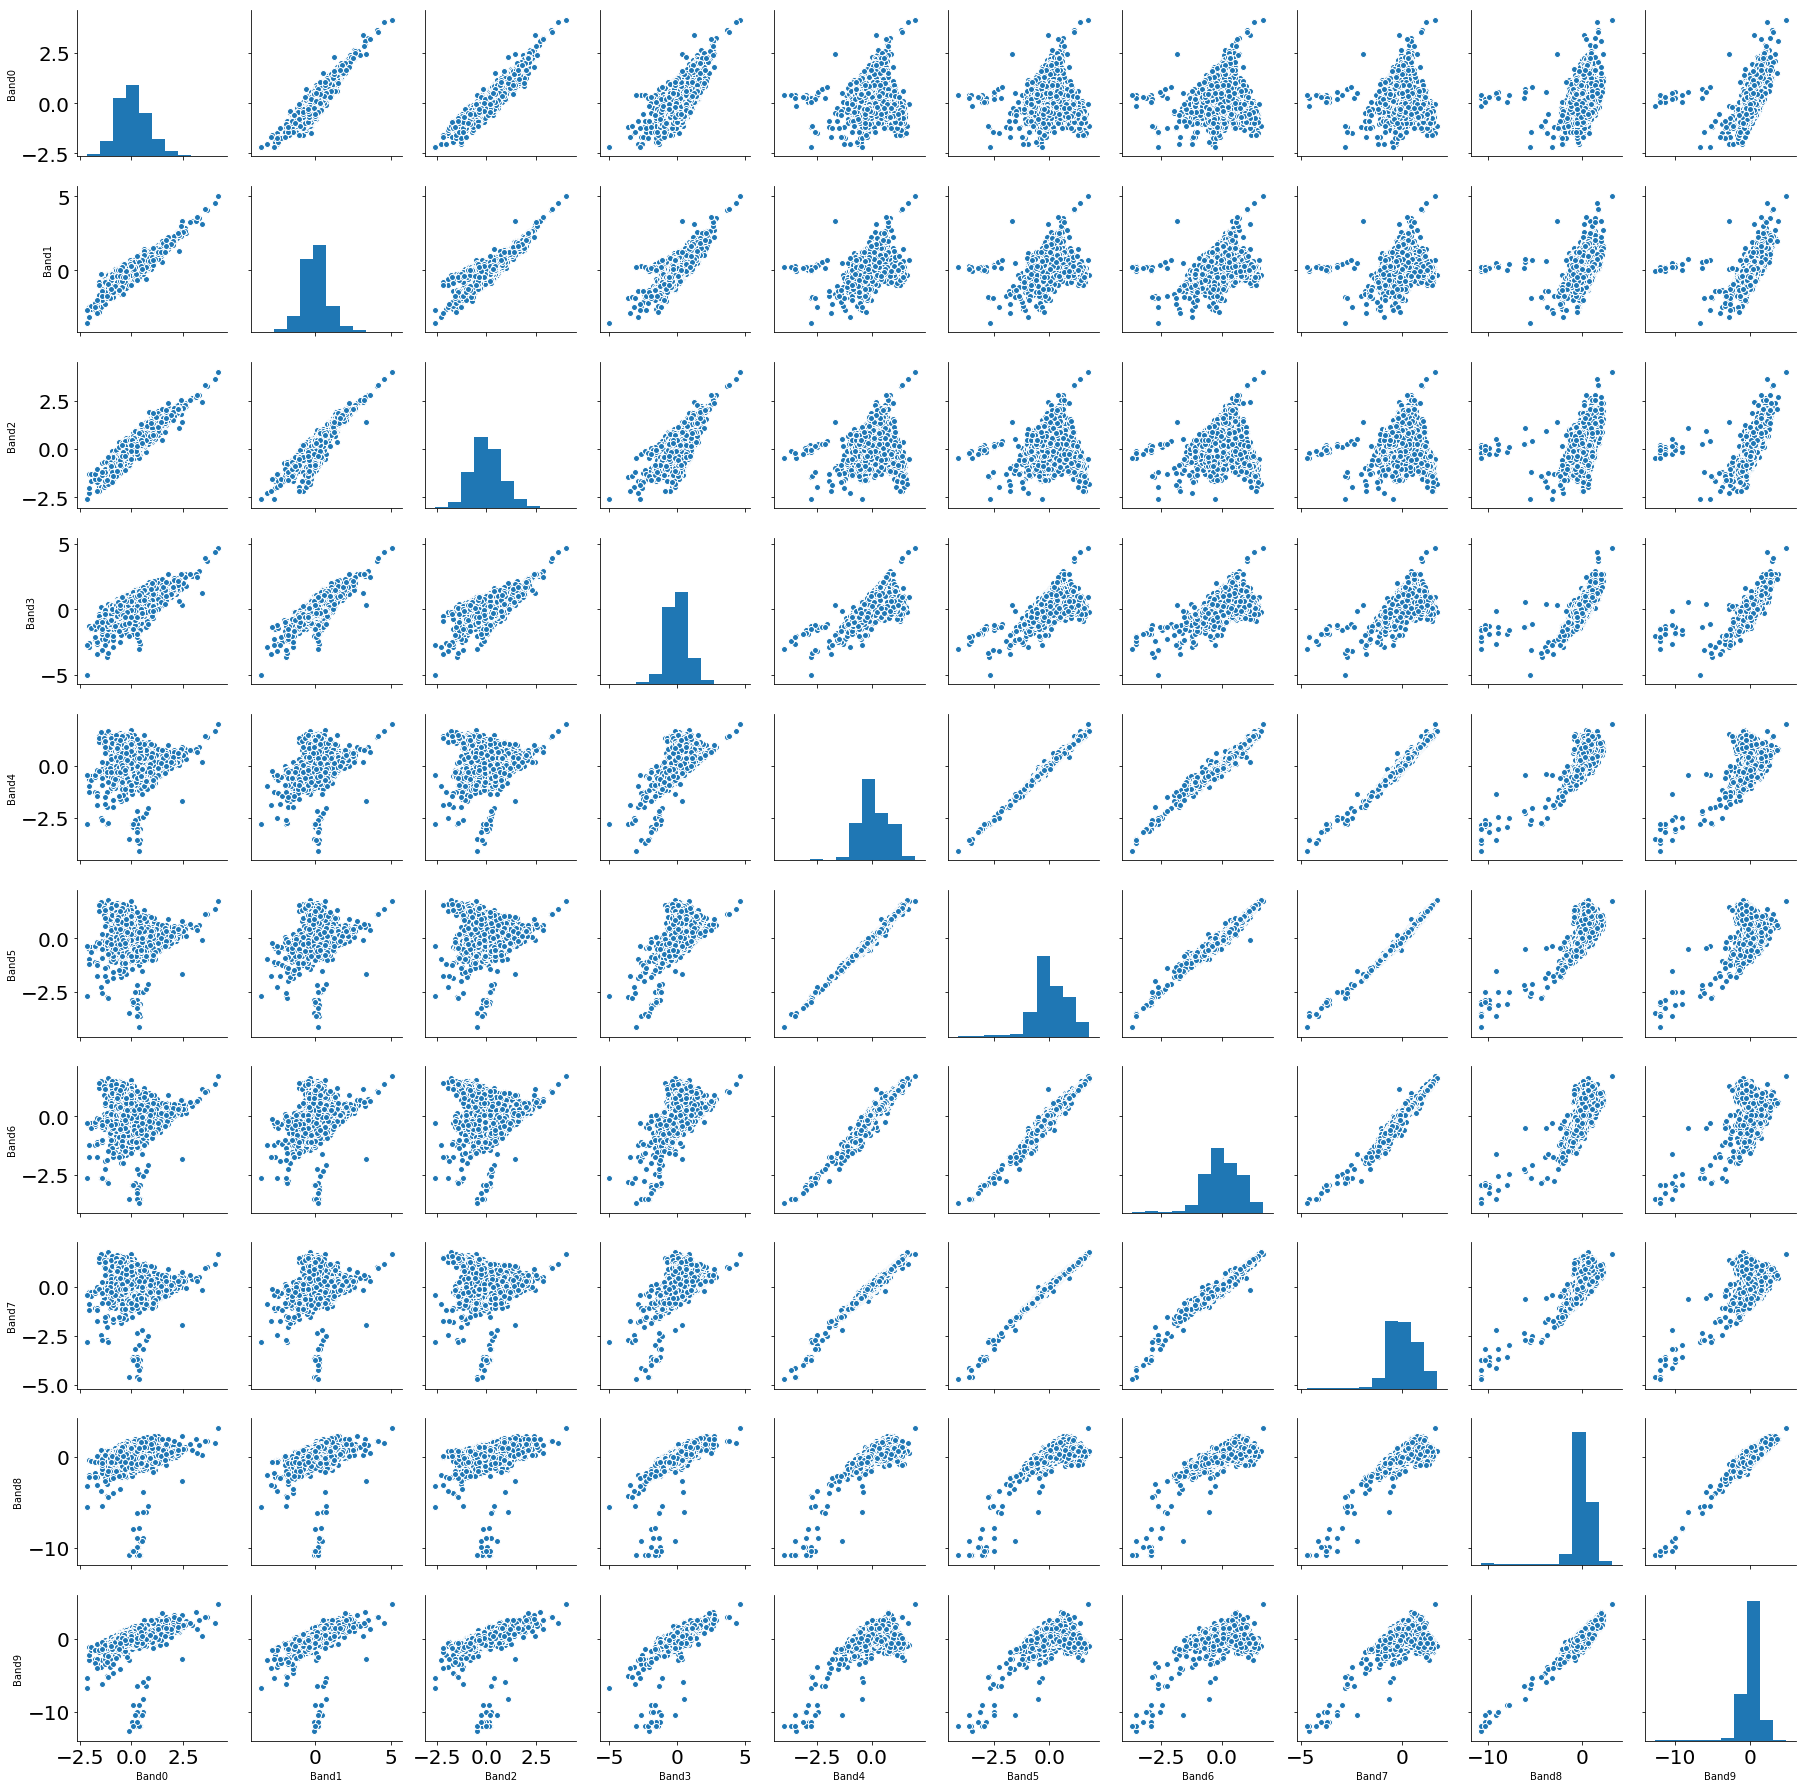

In [33]:
#rescale training data
scaled_train = scaler.transform(data_train)
scaled_df = pd.DataFrame(data=scaled_train, columns=stackdf.columns[:-1])
sn.pairplot(scaled_df)

### dimensionality reduction

Come of our bands are highly correlated, so we can check if we can reduce the dimensionality with a principal component analysis. This is by no means crucial with only 10 input dimensions, but can help significantly in higher-dimensional problems.

In [34]:
from sklearn.decomposition.pca import PCA

pca = PCA(n_components=0.99)
pca.fit(scaled_train)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
print('number of components = {}'.format(pca.n_components_))
print('explained variance = : ',pca.explained_variance_ratio_)

number of components = 4
explained variance = :  [ 0.63901113  0.23484351  0.10838394  0.00866561]


In this case, PCA reduces the number of dimensions by a factor of 2, while retaining 99% of the variance in the data set.

In [36]:
#apply transformation to our scaled training data
reduced_train = pca.transform(scaled_train)
reduced_train.shape

(1856, 4)

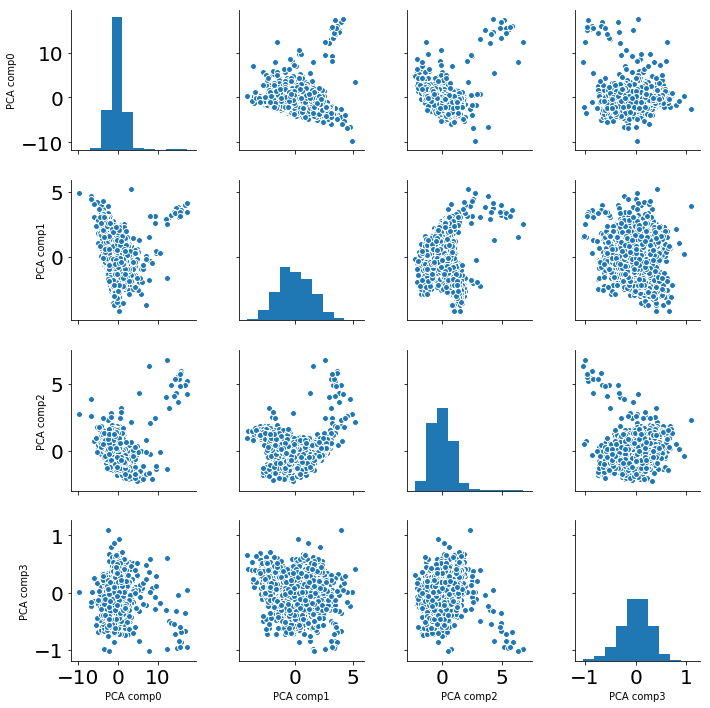

In [37]:
reduced_df = pd.DataFrame(data=reduced_train, 
                          columns=['PCA comp{}'.format(i) for i in range(pca.n_components_)])
sn.pairplot(reduced_df)

### Support Vector Machine classifier

Here we train a simple SVM classifier on our rescaled and reduced training data.

In [38]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(reduced_train,target_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Crucially, we need to apply the same transformations to our test data set.

In [39]:
scaled_test = scaler.transform(data_test)
reduced_test = pca.transform(scaled_test)
predicted = clf.predict(reduced_test)
print('SVM classification accuracy = {:3.2f}'.format(clf.score(reduced_test,target_test)))

SVM classification accuracy = 0.80


Not bad for such a simple model, but obviously still with a lot of scope for improvement.

We can also predict the probabilities of any given pixel belonging to a brownfield.

In [40]:
clf.predict_proba(reduced_test)[:10]

array([[ 0.8594949 ,  0.1405051 ],
       [ 0.1588669 ,  0.8411331 ],
       [ 0.86037909,  0.13962091],
       [ 0.44441889,  0.55558111],
       [ 0.190783  ,  0.809217  ],
       [ 0.15495178,  0.84504822],
       [ 0.15117871,  0.84882129],
       [ 0.56247948,  0.43752052],
       [ 0.68200911,  0.31799089],
       [ 0.14629957,  0.85370043]])

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predicted,target_test)

array([[189,  38],
       [ 54, 184]])

### Let's explore some other classifiers. Also, we can chain all these steps into a pipeline.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.99)),
    ('model', KNeighborsClassifier()),
])

In [43]:
pipeline.fit(data_train, target_train)
predicted_knn = pipeline.predict(data_test)
print('KNN classification accuracy = {:3.2f}'.format(pipeline.score(data_test,target_test)))

KNN classification accuracy = 0.77


In [44]:
from sklearn.neural_network import MLPClassifier
pipeline2 = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.99)),
    ('model', MLPClassifier()),
])

In [45]:
pipeline2.fit(data_train, target_train)
predicted_NN = pipeline2.predict(data_test)
print('Neural network classification accuracy = {:3.2f}'.format(pipeline2.score(data_test,target_test)))

Neural network classification accuracy = 0.80


#### Caveat: 
A prediction accuracy of 80-85% sounds already pretty good. However, we have to keep in mind that such a classifier would be run on a satellite image with millions of pixels, and maybe 1000 actual brownfield sites. So this could leave us with more false positives than true brownfield sites. 

However, so far we have only used the default settings of the various algorithms. Quite likely we could further improve the classification accuracy by tweaking the details of the algorithm. In particular, we should try to minimize the rate of false positives, i.e. non-brownfield sites that are mistakenly classified as brownfield sites.

### Other ideas for improvement
- So far we have only used the central pixel corresponding to the brownfield site coordinates, because detailed shape information (e.g. polygon data) was not available. With the full shape information, we could get a better 'spectrum' of the brownfield sites, which should significantly improve our classification.
- One could try to segment the satellite images, e.g. by a watershed transform. In combination with the above, one could compare entire areas against brownfield sites.
- Use other information (not just coordinates) from the brownfield pilot register.